# Figures (Manuscript Revisions)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context('notebook', font_scale=1.25)
np.random.seed(47404)
%matplotlib inline

## Figure 1: Panels C/D should reflect SEM.

In [ ]:
import ptitprince as pt
from pandas import read_csv
sns.set_context('notebook', font_scale=2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and preprocess data. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
df = read_csv('behavior/EMOTE_behav_data.csv')

## Prepare data.
df.DBS = np.where(df.DBS,'ON','OFF')
df.interference = np.where(df.interference, 'Interference', 'Control')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Interference effect.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, axes = plt.subplots(1,2,figsize=(14,7),sharey=True)

## Define metadata.
x, y = 'interference', 'origResponseTimes'
order = ['Control','Interference']
palette = ['#984EA3','#4DAF4A']

## Half-violin plot.
pt.half_violinplot(x, y, data=df, order=order, palette=palette, scale='area',
                   bw=0.2, cut=0, width=0.5, inner=None, ax=axes[0])

## Point plot.
sns.stripplot(x, y, data=df, order=order, palette=palette, edgecolor='w', 
              alpha=0.9, size=2, zorder=0, ax=axes[0])

## Boxplot overlay.
sns.boxplot(x, y, data=df, order=order, color='k', zorder=10, showcaps=True,
            width=0.15, linewidth=2, boxprops={'facecolor':'none', "zorder":10},
            showfliers=False, whiskerprops={'linewidth':2, "zorder":10},
            saturation=1, ax=axes[0])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### DBS effect.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
x, y = 'DBS', 'origResponseTimes'
order = ['OFF','ON']
palette = ['#377EB8','#E41A1C']

## Half-violin plot.
pt.half_violinplot(x, y, data=df, order=order, palette=palette, scale='area',
                   bw=0.2, cut=0, width=0.5, inner=None, ax=axes[1])

## Point plot.
sns.stripplot(x, y, data=df, order=order, palette=palette, edgecolor='w', 
              alpha=0.9, size=2, zorder=0, ax=axes[1])

## Boxplot overlay.
sns.boxplot(x, y, data=df, order=order, color='k', zorder=10, showcaps=True,
            width=0.15, linewidth=2, boxprops={'facecolor':'none', "zorder":10},
            showfliers=False, whiskerprops={'linewidth':2, "zorder":10},
            saturation=1, ax=axes[1])
    
## Add details / clean up.
axes[0].set(xlim=(-0.45, 1.15), xticks=[-0.1, 0.9], xlabel='Conflict', 
            yticks=[0.5,1.,1.5,2.], ylabel='Response Time (s)')
axes[0].set_xticklabels(['Control','Interference'], ha='center')
axes[1].set(xlim=(-0.45, 1.15), xticks=[-0.125, 0.875], xlabel='DBS', ylabel=None)
axes[1].set_xticklabels(['OFF','ON'], ha='center')
    
sns.despine()
plt.tight_layout()
plt.savefig('plots/natcomm/fig1cd.png', dpi=180)
plt.savefig('plots/natcomm/fig1cd.svg', dpi=180)
plt.close()

## Figure 2: Panels E/F should reflect SEM.

In [3]:
from pandas import DataFrame, read_csv
sns.set_context('notebook', font_scale=2.4)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters
space = 'source'
model_name = 'revised'
contrast = 'DBS'

## Label parameters.
labels = ['dlpfc_5-lh', 'dlpfc_4-lh', 'pcc-lh']
xlabels = ['aIFG', 'aMFG 2', 'mCC']

## Define averaging parameters.
baseline = (-0.5, -0.1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
analyses = []
freqs = []
rois = []
values = []

for analysis in ['stim','resp']:
        
    for label, xlabel in zip(labels,xlabels):
    
        for freq, ffreq in zip(['theta','alpha','beta'],
                               [r'$\theta$',r'$\alpha$',r'$\beta$']):
    
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Load data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Load trial information
            info = read_csv(os.path.join(space, 'afMSIT_%s_info.csv' %space))

            ## Load source data.
            npz = np.load(os.path.join(space, 'afMSIT_%s_%s_%s_%s.npz' %(space,analysis,label,freq)))
            data = npz['data']
            times = npz['times']

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Compute differences.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Define mask.
            if analysis == 'stim': tmin, tmax = 0.4, 0.8
            elif analysis == 'resp': tmin, tmax = -0.2, 0.2
            time_ix, = np.where(np.logical_and(times >= tmin, times <= tmax)) 
                
            ## Compute averages within window.
            delta = []

            for subj in info.Subject.unique():

                ## Define indices.
                ix_off, = np.where(np.logical_and(info.Subject==subj, info.DBS==0))
                ix_on, = np.where(np.logical_and(info.Subject==subj, info.DBS==1))

                ## Compute mean timecourse within condition
                off = data[ix_off][:,time_ix]
                on = data[ix_on][:,time_ix]

                ## Compute and store difference.
                delta.append( np.mean(on - off) )
            
            ## Append information.
            analyses += [analysis] * len(delta)
            freqs += [ffreq] * len(delta)
            rois += [xlabel]* len(delta)
            values += delta

ValueError: operands could not be broadcast together with shapes (141,41) (137,41) 

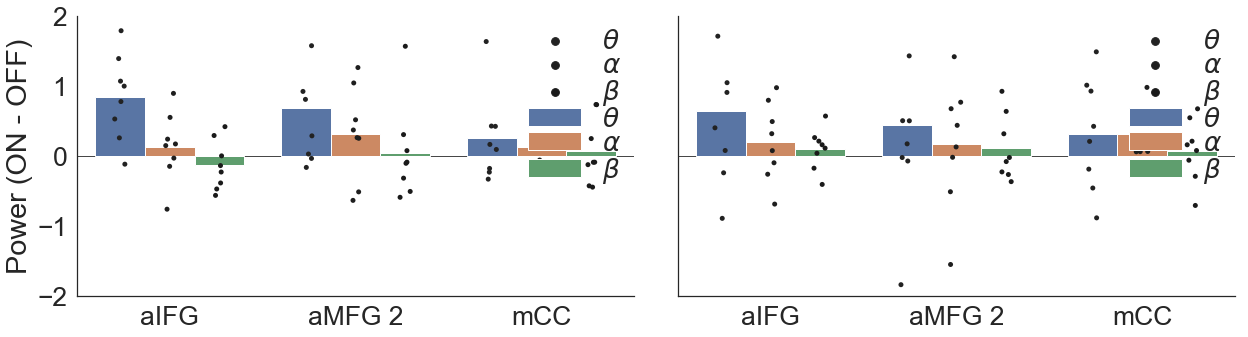

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute differences.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Conver to DataFrame.
df = DataFrame([analyses, freqs, rois, values], index=('Analysis','Freq','ROI','Delta')).T
df.Delta = df.Delta.astype(float)
hue_order = [r'$\theta$',r'$\alpha$',r'$\beta$']

## Plot.
palette = sns.color_palette(n_colors=3)
g = sns.FacetGrid(df, col='Analysis', height=6, aspect=1.5, palette=palette)
g.map(sns.stripplot, 'ROI', 'Delta', 'Freq', order=xlabels, hue_order=hue_order, 
      color='k', dodge=True)
g.map(sns.barplot, 'ROI', 'Delta', 'Freq', order=xlabels, hue_order=hue_order, 
      palette=palette, ci=None)

## Add flourishes.
for n, ax in enumerate(g.axes.squeeze()):
    x1, x2 = ax.get_xlim()
    ax.hlines(0,x1,x2,lw=0.8,zorder=0)
    ax.set(xlabel = '', xlim=(x1,x2), ylim=(-2, 2), title='')
    ax.legend(loc=1, labelspacing=0, borderpad=0, frameon=False)
    if not n: ax.set_ylabel('Power (ON - OFF)')
        
plt.savefig('plots/natcomm/fig2ef.png', dpi=180)
plt.savefig('plots/natcomm/fig2ef.svg', dpi=180)
plt.show()

In [ ]:
info

## Figure 3

In [ ]:
import matplotlib.gridspec as gridspec
from pandas import DataFrame, Series, read_csv
from scipy.stats import pearsonr
from sklearn.metrics import auc, roc_curve
sns.set_context('notebook', font_scale=2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
space = 'source'
model = 'revised'
analysis = 'stim'
domain = 'frequency'
contrast = 'DBS'
label = 'dlpfc_5-lh'
freq = 'theta'
fdr = 0.05
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare clinical data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

scores = read_csv('behavior/Subject_Rating_Scales.csv', index_col=0)
subjects = scores.index

madrs = scores['MADRS_Now'] - scores['MADRS_Base']
mania = scores['Hypomania']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare reaction time data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

rt = read_csv('behavior/EMOTE_behav_data.csv')
rt = rt.groupby(['DBS','subject']).origResponseTimes.mean()
rt = rt[1] - rt[0]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare power data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

info = read_csv(os.path.join(space, 'afMSIT_%s_info.csv' %space))

## Load and limit cluster results.
results = read_csv(os.path.join(space, 'results', '%s_%s_%s_results.csv' %(model,analysis,domain)))
results = results[results.Contrast==contrast]
results = results[results.FDR<fdr]
results = results[results.Label == label].reset_index(drop=True)

## Load time series data.
npz = np.load(os.path.join(space, 'afMSIT_%s_%s_%s_%s.npz' %(space, analysis, label, freq)))
data = npz['data']
times = npz['times']

## Compute condition differences.
delta = np.zeros(subjects.shape[0])
mask = (times >= results.Tmin.min()) & (times <= results.Tmax.max()) # NOTE: collapsing across clusters

for m, subject in enumerate(subjects):
    i, = np.where((info['Subject']==subject)&(info[contrast]==0))
    j, = np.where((info['Subject']==subject)&(info[contrast]==1))
    delta[m] += (data[j][:,mask].mean(axis=0) - data[i][:,mask].mean(axis=0)).mean()
delta = Series(delta, index=subjects)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Construct DataFrame.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#  
np.random.seed(47404)

## Concatenate data.
df = DataFrame([madrs,mania,rt,delta], index=['MADRS','Hypomania','RT','Delta']).T

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 

def swap_arr(x,y):
    return y.copy(), x.copy()

def simple_roc(y,x):
    '''http://blog.revolutionanalytics.com/2016/08/roc-curves-in-two-lines-of-code.html'''
    assert np.all(np.in1d(y, [0,1]))
    y = (y[np.argsort(x)[::-1]]).astype(bool)
    return np.cumsum(y, dtype=float) / y.sum(), np.cumsum(~y, dtype=float) / (~y).sum()

def ROC(y,x):
    
    ## Compute RoC, AUC.
    tpr, fpr = simple_roc(y,x)
    roc_auc = auc(fpr, tpr)
    
    ## Correct for misidentification.
    if roc_auc < 0.5:
        roc_auc = 1 - roc_auc
        tpr, fpr = swap_arr(tpr, fpr)
        
    return tpr, fpr, roc_auc

## Initialize figure.
fig  = plt.figure(figsize=(16,8))

## Define plotting variables.
colors = np.array([['#1f77b4','#2ca02c'], ['#d62728', '#9467bd']])
xticklabels = [['No Response', 'Remission'], ['No History', 'Converted']]
ylabels = [r'$\Delta$ RT (s)', r'$\Delta$ $\theta$-power (dB)']

for n, xlabel in enumerate(['MADRS', 'Hypomania']):
    
    for m, ylabel in enumerate(['RT','Delta']):
           
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Preparations.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
            
        ## Initialize axes.
        if not n: top, bottom = 0.95, 0.6
        else: top, bottom = 0.425, 0.1
        if not m: left, right = 0.08, 0.435
        else: left, right = 0.565, 0.95
        gs = gridspec.GridSpec(1,2)
        gs.update(left=left, right=right, top=top, bottom=bottom, wspace=0.4)
        
        ## Extract variables.
        x, y = df[[xlabel,ylabel]].dropna().as_matrix().T
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Correlation Plot.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
    
        ## Plot correlation.
        ax = plt.subplot(gs[0])
        sns.regplot(x, y, df, color=colors[n,m], ax=ax)
        ax.scatter(df.loc[['M5','S2'],xlabel].values,
                   df.loc[['M5','S2'],ylabel].values,
                   color=colors[n,m],marker='s',zorder=10,s=50)
        
        ## Add flourishes.
        if not n and not m: ax.set(xticks=[-40,-20,0], xlabel=r'$\Delta$ MADRS')
        elif not n:  ax.set(xticks=[-26,-13,0], xlabel=r'$\Delta$ MADRS')
        else: ax.set(xticks=[0,1], xticklabels=xticklabels[n])
        if not m: ax.set(ylim=(-0.15, 0.10), yticks=[-0.10,0.0,0.10],
                         ylabel=ylabels[m])
        else: ax.set(ylim=(-0.5,2), yticks=np.linspace(-0.5,2,3),
                     ylabel=ylabels[m])
        ax.tick_params(axis='x', which='major', pad=15)
    
        ## Add text.
        r, p = pearsonr(x,y)
        if not m and n: 
            ax.annotate('r = %0.2f, p = %0.2f' %(r,p), xy=(0,0), xytext=(0.05,0.05),
                              xycoords = 'axes fraction', fontsize=16)
        else:
            ax.annotate('r = %0.2f, p = %0.2f' %(r,p), xy=(0,0), xytext=(0.3,0.05),
                              xycoords = 'axes fraction', fontsize=16)
    
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### RoC plots.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
    
        if xlabel == 'MADRS':
            x = np.where(scores['MADRS_Now'] / scores['MADRS_Base'] > 0.5, 0, 1)
            x = x[df[ylabel].notnull()]
    
        ## Initialize plot.
        ax = plt.subplot(gs[1])
        ax.plot(np.linspace(0,1,10),np.linspace(0,1,10),lw=1,linestyle='--',color='k')
        
        ## Plot true RoC.
        tpr, fpr, roc_auc = ROC(x, y)
        ax.plot(fpr, tpr, lw=2, color=colors[n,m])
        
        auc_sim = []
        for i in range(1000):
            
            ## Shuffle values.
            if i: ix = np.random.choice(np.arange(len(x)), len(x), replace=True)
            else: ix = np.arange(len(x))
            x_p, y_p = x[ix].copy(), y[ix].copy() 
            
            ## Compute AUC. 
            _, _, sim = ROC(x_p, y_p)
            auc_sim.append( sim )
            
        ## Plot bootstrapped CI.
        text = 'AUC = %0.2f [%0.2f, %0.2f]' %(roc_auc, np.nanpercentile(auc_sim, 2.5),
                                              np.nanpercentile(auc_sim, 97.5))
        ax.annotate(text, xy=(0,0), xytext=(0.15,0.05), xycoords = 'axes fraction', 
                    fontsize=16)
        
        ## Add flourishes.
        ax.set(xticks=np.linspace(0,1,3), xlim=(-0.01,1.00), xlabel='FPR', 
               yticks=np.linspace(0,1,3), ylim=(0.00,1.01), ylabel='TPR')
    
sns.despine()
plt.savefig('plots/natcomm/fig3.png', dpi=180)
plt.savefig('plots/natcomm/fig3.svg', dpi=180)
plt.close()

## Supplementary A: EMOTE EEfRT RT Plot

In [ ]:
from pandas import read_csv
sns.set_context('notebook', font_scale=1.5)

## Load data.
data = read_csv('behavior/eefrt_group_data.csv')

## Average within subjects.
data = data.groupby(['Subject','DBS']).RT.mean().reset_index()
data = data.pivot_table('RT','Subject','DBS')
data = data.values.T

## Plot.
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(data,marker='o',color='grey',markersize=3,lw=1.5,alpha=0.9)
ax.plot(data.mean(axis=1),marker='o',color='k',markersize=6,lw=3.5,alpha=0.9)
ax.set(xlim=(-0.5,1.5), xticks=(0,1), xticklabels=('OFF', 'ON'),
       ylabel='Median Response Time (s)')

## Draw subject labels.
labels = ['S6','S12','S7','S9','S10','S1','S3','S8','S2']
for n, (y, label) in enumerate(zip(data[-1], labels)): 
    bump = 0
    if n == 1: bump = -0.04
    if n == 2: bump = 0.01
    if n == 4: bump = -0.025
    ax.text(1.05, y+bump, label, fontsize=12)
ax.text(1.05, np.mean(data[-1]), 'Group', fontsize=12)
    
sns.despine()
plt.tight_layout()
plt.savefig('plots/natcomm/eefrt.png', dpi=180)
plt.close()

## Supplementary 5: Individual Resting State PSD

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import Epochs, make_fixed_length_events, pick_channels, read_proj, set_log_level
from mne.io import Raw
from mne.time_frequency import psd_multitaper
sns.set_style('white')
sns.set_context('notebook', font_scale=2.5)
set_log_level(verbose=False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define Parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
subjects = ['BRTU', 'CHDR', 'JADE', 'KARA', 'S2']
conds = ['resting_dbsoff_eo', 'resting_dbson_eo']

## Filtering parameters.
l_freq = 0.5
h_freq = 50
l_trans_bandwidth = l_freq / 2.
h_trans_bandwidth = 1.0
filter_length = '20s'
n_jobs = 3

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

root_dir = '../resting/raw/'

PSD = []
for subject in subjects:
    
    s = []
    for cond in conds:
        
        ## Load data.
        raw = Raw('%s/%s_%s_raw.fif' %(root_dir, subject, cond), preload=True)

        ## Apply projection.
        proj = '%s/%s_%s-proj.fif' %(root_dir, subject, cond)
        if os.path.isfile(proj): raw.add_proj(read_proj(proj))
        else: raw.set_eeg_reference()
        raw = raw.apply_proj()
        
        ## Filter raw.
        raw = raw.filter(l_freq, h_freq, filter_length=filter_length, 
                         l_trans_bandwidth=l_trans_bandwidth,
                         h_trans_bandwidth=h_trans_bandwidth)
        
        ## Create epochs.
        picks = pick_channels(raw.ch_names, ['FZ'])
        events = make_fixed_length_events(raw, 1, start=1, stop=61, duration=1)
        epochs = Epochs(raw, events, tmin=-0.2, tmax=1, baseline=(None,0), 
                        reject=dict(eeg=150e-6))
        epochs = epochs.load_data().pick_channels(['FZ'])
        epochs.drop_bad()
        
        ## Compute PSD
        psd, freqs = psd_multitaper(epochs, fmin=l_freq, fmax=30,  n_jobs=3)
        s.append(np.median(psd, axis=0).squeeze())
        
    PSD.append(s)
    
PSD = np.array(PSD)
PSD = 10 * np.log10(PSD)

In [ ]:
sns.set_context('notebook', font_scale=1.5)

## First plot.
fig, axes = plt.subplots(1,5,figsize=(15,3.5),sharex=True,sharey=True)
axes = axes.flatten()

titles = [6, 12, 11, 10, 2]
order =  np.array([1,  4,  3,  2, 0])

for i, psd, title in zip(order, PSD, titles):
    for arr, color, label in zip(psd, ['#4c72b0','#c44e52'], ['DBS OFF', 'DBS ON']):
        axes[i].plot(freqs, arr, color=color, label=label, lw=3)
    axes[i].fill_between([4,8],-106,-75,color='k',alpha=0.05)
    axes[i].set(xticks=[1,10,20,30], xlabel='Freq (Hz)', ylim=(-106,-75), title='S%s' %title)
axes[0].set_ylabel('Power (dB)')
axes[0].legend(loc=1, frameon=False, borderpad=-0.5, fontsize=14)
    
sns.despine()
plt.tight_layout()
plt.savefig('plots/natcomm/S5c_resting_psd.png', dpi=180)
plt.savefig('plots/natcomm/S5c_resting_psd.svg', dpi=180)
    
## Second plot.
fig, ax = plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
ax.plot(freqs, np.mean(PSD, axis=0)[0], color='#4c72b0', label='DBS OFF', lw=3)
ax.plot(freqs, np.mean(PSD, axis=0)[1], color='#c44e52', label='DBS ON', lw=3)
ax.fill_between([4,8],-106,-75,color='k',alpha=0.05)
ax.set(xticks=[1,10,20,30], xlabel='Freq (Hz)', ylabel='Power (dB)', ylim=(-106,-75), title='Group')
ax.legend(loc=1, frameon=False, borderpad=0, fontsize=14)

sns.despine()
plt.tight_layout()
plt.savefig('plots/natcomm/S5b_resting_psd.png', dpi=180)
plt.savefig('plots/natcomm/S5b_resting_psd.svg', dpi=180)

In [ ]:
from scipy.stats import mannwhitneyu
mask = np.logical_and(freqs > 4, freqs < 8)
stat, pval = mannwhitneyu(*PSD[...,mask].mean(axis=-1).T)
print('stat = %0.2f, p = %0.3f' %(stat,pval))

## Supplementary C: Behavior Interaction

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set(style="white")
sns.set_context('notebook', font_scale=1.5)
np.random.seed(47404)
%matplotlib inline

## Load data.
data = read_csv('behavior/afMSIT_group_data.csv')
data = data[data.Exclude==0]
data['DBS'] = np.where(data.DBS, 'ON', 'OFF')
data['Interference'] = np.where(data.Interference, 'Interference', 'Control')

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,4))
palette=sns.color_palette(['#0571b0','#ca0020'])
sns.barplot('Interference','RT','DBS',data=data,palette=palette)
ax.set(xlabel='Conflict', ylabel='Response Time (s)', yticks=[0,0.5,1])
ax.legend(loc=2, borderpad=-0.1, frameon=False)

sns.despine()
plt.tight_layout()
plt.savefig('plots/natcomm/supp_behavior_interaction.png', dpi=180)
plt.savefig('plots/natcomm/supp_behavior_interaction.svg', dpi=180)
plt.close()

## Supplementary Figure (S3): Theta Oscillations

### Low Pass Power

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from mne.time_frequency import tfr_array_morlet
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot source time courses.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,6))
    
## Load metadata.
df = read_csv('source/afMSIT_source_info.csv')
    
## Define path.
fname = 'afMSIT_source_stim_dlpfc_5-lh_15.npz'
fname = os.path.join('source',fname)

## Load data.
npz = np.load(fname)
data, times = npz['data'], npz['times']

## Plot raw timecourses.
for i, color, label in zip([0,1], ['#0571b0','#ca0020'], ['OFF','ON']):
    ax.plot(data[df.DBS==i].mean(axis=0), color=color, lw=3, label=label)
ax.hlines(0,0,times.size,lw=0.5,zorder=0,alpha=0.4)

xticklabels = np.array([-0.9, -0.4, 0.0, 0.5, 1.0, 1.4])
xticks = np.array([np.argmin((times - (x + 0.5))**2) for x in xticklabels])

ax.set(xlim=(0,times.size), xticks=xticks, xticklabels=xticklabels, xlabel='Time (s)', 
        ylim=(-0.175, 0.125), yticks=np.arange(-0.15,0.16,0.05), 
        ylabel='Source Amplitude (dSPM)')
ax.legend(loc=4, frameon=False, borderpad=0)
sns.despine()
plt.tight_layout()
plt.savefig('plots/natcomm/figS3_stc.png', dpi=180)
plt.savefig('plots/natcomm/figS3_stc.svg', dpi=180)

### Non-phase locked power

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from mne.time_frequency import tfr_array_morlet
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Data parameters.
subjects = ['BRTU','CHDR', 'CRDA', 'JADE', 'JASE', 'M5', 'MEWA', 'S2']
h_freq = 50

## Time-frequency parameters.
freqs = np.logspace( np.log10(2), np.log10(50), num=25)
n_cycles = 3
baseline = (-0.5, -0.1)
Fs = 1450.
decim = 14

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Preprocessing main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load metadata.
df = read_csv('source/afMSIT_source_info.csv')

ltcs = []
for subject in subjects:

    ## Load NPZ.
    npz = np.load('source/stcs/%s_msit_stim_dSPM_50_epochs.npz' %subject)

    ## Get label index and extract.
    ix = npz['labels'].tolist().index(b'dlpfc_5-lh')
    arr = npz['ltcs'][:,ix,:]

    ## Phase-lock removal.
    copy = df[df.Subject==subject].copy()
    for dbs in [0,1]:
        for cond in [0,1]:
            ix, = np.where((copy.DBS==dbs)&(copy.Interference==cond))
            arr[ix] -= np.median(arr[ix], axis=0)
            
    ## Append.
    ltcs.append(arr)

## Concatenate.
ltcs = np.concatenate(ltcs, axis=0)
times = npz['times']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute power.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

print('Computing single trial power.')
ltcs = np.expand_dims(ltcs,1)
power = tfr_array_morlet(ltcs, sfreq=Fs, freqs=freqs, n_cycles=n_cycles, 
                         output='power', decim=decim, verbose=False)
power = power.squeeze()
times = times[::decim]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Normalization.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Make time mask.
mask = (times >= baseline[0]) & (times <= baseline[1])

## Average within subjects / condition.
averages = []
for subject in subjects:
    
    for dbs in [0,1]:
        
        ## Identify indices.
        ix, = np.where((df.Subject==subject)&(df.DBS==dbs))
        
        ## Average.
        arr = np.median(power[ix], axis=0).copy()
        
        ## Compute baseline.
        bl = np.median(arr[:,mask], axis=-1)
        
        ## Normalize.
        arr = (arr.T / bl).T
        
        ## Append.
        averages.append(arr)
        
## Compute baseline.
grand_average = 10 * np.log10(np.mean(averages, axis=0))

## Restrict times.
indices, = np.where(np.logical_and(times >= -0.5, times <= 1.9))
grand_average = grand_average[:, indices]
times = times[indices]

NPLGA = grand_average.copy()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot power.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,6))

## Plot power.
xticklabels = np.array([-0.9, -0.4, 0.0, 0.5, 1.0, 1.4])
xticks = np.array([np.argmin((times - (x + 0.5))**2) for x in xticklabels])
yticks = [0,3,5,10.5,13.33,17.25,20.1,24]
yticklabels = [2,3,4,8,12,20,30,50]

sns.heatmap(grand_average, center=0, vmin=-2.5, vmax=2.5, 
            cbar_kws=dict(label='Power (dB)'), ax=ax)
ax.invert_yaxis()
ax.set(xticks=xticks, xticklabels=xticklabels, xlabel='Time (s)',
       yticks=yticks, yticklabels=yticklabels, ylabel='Freq (Hz)')
ax.set_xticklabels(xticklabels, rotation=0)

plt.tight_layout()
plt.savefig('plots/natcomm/figS3_tfr_nonphaselocked.png', dpi=180)
plt.savefig('plots/natcomm/figS3_tfr_nonphaselocked.svg', dpi=180)

### Phase locked power

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from mne.time_frequency import tfr_array_morlet
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Data parameters.
subjects = ['BRTU','CHDR', 'CRDA', 'JADE', 'JASE', 'M5', 'MEWA', 'S2']
h_freq = 50

## Time-frequency parameters.
freqs = np.logspace( np.log10(2), np.log10(50), num=25)
n_cycles = 3
baseline = (-0.5, -0.1)
Fs = 1450.
decim = 14

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Preprocessing main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load metadata.
df = read_csv('source/afMSIT_source_info.csv')

ltcs = []
for subject in subjects:

    ## Load NPZ.
    npz = np.load('source/stcs/%s_msit_stim_dSPM_50_epochs.npz' %subject)

    ## Get label index and extract.
    ix = npz['labels'].tolist().index(b'dlpfc_5-lh')
    arr = npz['ltcs'][:,ix,:]
            
    ## Append.
    ltcs.append(arr)

## Concatenate.
ltcs = np.concatenate(ltcs, axis=0)
times = npz['times']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute power.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

print('Computing single trial power.')
ltcs = np.expand_dims(ltcs,1)
power = tfr_array_morlet(ltcs, sfreq=Fs, freqs=freqs, n_cycles=n_cycles, 
                         output='power', decim=decim, verbose=False)
power = power.squeeze()
times = times[::decim]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Normalization.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Make time mask.
mask = (times >= baseline[0]) & (times <= baseline[1])

## Average within subjects / condition.
averages = []
for subject in subjects:
    
    for dbs in [0,1]:
        
        ## Identify indices.
        ix, = np.where((df.Subject==subject)&(df.DBS==dbs))
        
        ## Average.
        arr = np.median(power[ix], axis=0).copy()
        
        ## Compute baseline.
        bl = np.median(arr[:,mask], axis=-1)
        
        ## Normalize.
        arr = (arr.T / bl).T
        
        ## Append.
        averages.append(arr)
        
## Compute baseline.
grand_average = 10 * np.log10(np.mean(averages, axis=0))

## Restrict times.
indices, = np.where(np.logical_and(times >= -0.5, times <= 1.9))
grand_average = grand_average[:, indices]
times = times[indices]

In [ ]:
test = grand_average - NPLGA

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot power.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,6))

## Plot power.
xticklabels = np.array([-0.9, -0.4, 0.0, 0.5, 1.0, 1.4])
xticks = np.array([np.argmin((times - (x + 0.5))**2) for x in xticklabels])
yticks = [0,3,5,10.5,13.33,17.25,20.1,24]
yticklabels = [2,3,4,8,12,20,30,50]

sns.heatmap(test, center=0, vmin=-2.5, vmax=2.5, 
            cbar_kws=dict(label='Power (dB)'), ax=ax)
ax.invert_yaxis()
ax.set(xticks=xticks, xticklabels=xticklabels, xlabel='Time (s)',
       yticks=yticks, yticklabels=yticklabels, ylabel='Freq (Hz)')
ax.set_xticklabels(xticklabels, rotation=0)

plt.tight_layout()
plt.savefig('plots/natcomm/figS3_tfr_phaselocked.png', dpi=180)
plt.savefig('plots/natcomm/figS3_tfr_phaselocked.svg', dpi=180)